# Legacy Halos - Paper I Figures

This notebook contains all the code used to generate the figures in Paper 1.

### Imports and plotting preferences

In [3]:
import os, warnings, pdb
import numpy as np
import numpy.ma as ma

import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter

In [4]:
import fitsio
import seaborn as sns
from astropy.io import fits
from astropy.table import Table

In [5]:
import legacyhalos.io
import legacyhalos.misc
from legacyhalos.misc import lambda2mhalo, statsinbins

In [6]:
sns, colors = legacyhalos.misc.plot_style(paper=True)
%matplotlib inline

### Specify which figures to (re)make

In [7]:
remake_radec = True

### Read the data set some paths

In [8]:
sampledir = legacyhalos.io.sample_dir()
figdir = os.path.join(legacyhalos.io.legacyhalos_dir(), 'science', 'paper1', 'figures')

In [9]:
dr = 'dr6-dr7'

In [10]:
sample = legacyhalos.io.read_sample(verbose=True)
isedfit_lsphot = legacyhalos.io.read_sample(isedfit_lsphot=True, verbose=True)
isedfit_sdssphot = legacyhalos.io.read_sample(isedfit_sdssphot=True, verbose=True)

Read galaxy indices 0 through 266217 (N=266218) from /Users/ioannis/research/projects/legacyhalos/sample/legacyhalos-sample-dr6-dr7.fits
Read galaxy indices 0 through 266217 (N=266218) from /Users/ioannis/research/projects/legacyhalos/sample/isedfit-lsphot-dr6-dr7.fits
Read galaxy indices 0 through 229492 (N=229493) from /Users/ioannis/research/projects/legacyhalos/sample/isedfit-sdssphot-dr14.fits


Print some statistics:

In [11]:
medz = np.median(sample['Z'])
medlam = 10**np.median(np.log10(sample['LAMBDA_CHISQ']))
print(medz, medlam, lambda2mhalo(medlam, redshift=0.4))

0.405179 11.064069983 7.59303703816e+13


In [44]:
def mstar_label():
    return r'$\log_{10}\, (\mathcal{M}_{*}\ /\ h^{-2}\, \mathcal{M}_{\odot})$'

### Plot the stellar mass function.

In [76]:
smffile = os.path.join(sampledir, 'smf-dr6-dr7.fits')
smf, smfhdr = fitsio.read(smffile, ext=0, header=True)
smf.shape

(8, 5, 50)

In [66]:
def fig_smf(png=None):
    """Plot the SMF."""
    smffile = os.path.join(sampledir, 'smf-dr6-dr7.fits')
    print('Reading {}'.format(smffile))
    smf, smfhdr = fitsio.read(smffile, ext=0, header=True)
    smferr = fitsio.read(smffile, ext=1)
    #smf_err = smf_err / smf / np.log(10)
    #smf = np.log10(smf)
    
    nz, nlam, nmstar = smfhdr['NZ'], smfhdr['NLAM'], smfhdr['NMSTAR']
    print(nz, nlam, nmstar)
    zmin, zmax, zmid = np.zeros(nz), np.zeros(nz), np.zeros(nz)
    for ii in range(nz):
        zmin[ii] = smfhdr['ZMIN{:02d}'.format(ii)]
        zmax[ii] = smfhdr['ZMAX{:02d}'.format(ii)]
        zmid[ii] = smfhdr['ZMID{:02d}'.format(ii)]

    lmin, lmax, lmid = np.zeros(nlam), np.zeros(nlam), np.zeros(nlam)
    for ii in range(nlam):
        lmin[ii] = smfhdr['LAMMIN{:02d}'.format(ii)]
        lmax[ii] = smfhdr['LAMMAX{:02d}'.format(ii)]
        lmid[ii] = smfhdr['LAMMID{:02d}'.format(ii)]

    mstarmid = np.zeros(nmstar)
    for ii in range(nmstar):
        mstarmid[ii] = smfhdr['MMID{:02d}'.format(ii)]
        
    fig, ax = plt.subplots(nlam, nz, figsize=(14, 10), sharex=True, sharey=True)
    for ii in range(nz):
        for jj in range(nlam):
            good = smf[ii, jj, :] > 0
            if np.sum(good) > 0:
                mstar = mstarmid[good]
                smfplot = np.log10( smf[ii, jj, good] )
                smferrplot = smferr[ii, jj, good] / smf[ii, jj, good] / np.log(10)
                
                ax[jj, ii].fill_between(mstar, smfplot - smferrplot, smfplot + smferrplot)
                #ax[jj, ii].scatter(mstar, smfplot, s=20)
                ax[jj, ii].errorbar(mstar, smfplot, yerr=smferrplot, fmt='s', 
                                    markersize=5, capthick=2, capsize=2, 
                                    zorder=2)
            ax[jj, ii].set_xlim(9, 13.5)
            ax[jj, ii].set_ylim(-2, 5)
            
            ax[jj, ii].margins(0)
            ax[jj, ii].xaxis.set_major_locator(ticker.MultipleLocator(2))
                
            if jj == nlam - 1 and (ii % 2) == 0:
                ax[jj, ii].set_xlabel(mstar_label())
            if ii == 0 and (jj % 2) == 0:
                ax[jj, ii].set_ylabel(r'$\log_{10}\,\Phi\ ({\rm dex}^{-1})$')
            if ii == nz - 1:
                ax[jj, ii].text(0.95, 0.85, '${:.0f}<\lambda<{:.0f}$'.format(lmin[jj], lmax[jj]),
                                fontsize=12, va='center', ha='right', transform=ax[jj, ii].transAxes)
            if jj == 0:
                ax[jj, ii].set_title(r'${:.2f}<z<{:.2f}$'.format(zmin[ii], zmax[ii]), fontsize=12)
            
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    if png:
        pngfile = os.path.join(figdir, png)
        print('Writing {}'.format(pngfile))
        fig.savefig(pngfile, bbox_inches='tight')

Reading /Users/ioannis/research/projects/legacyhalos/sample/smf-dr6-dr7.fits
8 5 50
Writing /Users/ioannis/research/projects/legacyhalos/science/paper1/figures/smf.png


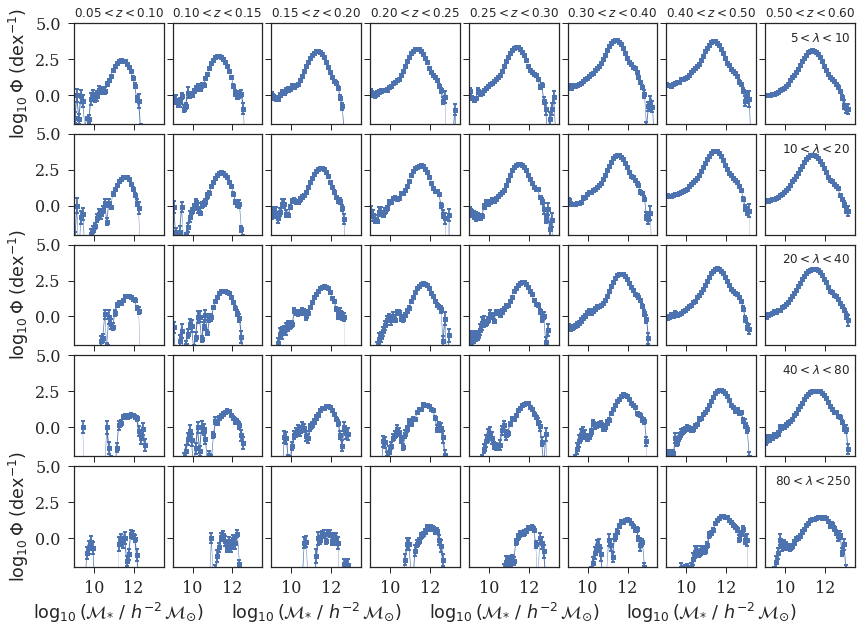

In [68]:
fig_smf(png='smf.png')

### Plot n(z) and n(lambda).

In [260]:
def fig_noflambda(lamplot=[5, 20, 50], png=None):
    """Plot n(lambda) for several bins of redshift and compare against a few 
    different mass-richness relations.
    
    """
    noflambdafile = os.path.join(sampledir, 'noflambda-dr6-dr7.fits')
    print('Reading {}'.format(noflambdafile))
    noflambda, noflambdahdr = fitsio.read(noflambdafile, ext=0, header=True)
    noflambda_err = fitsio.read(noflambdafile, ext=1)
    noflambda_err = noflambda_err / noflambda / np.log(10)
    noflambda = np.log10(noflambda)
    
    _lmin, _lmax = noflambdahdr['LAMMIN'], noflambdahdr['LAMMAX']
    dlam, nlam = noflambdahdr['DLAM'], noflambdahdr['NLAM']
    
    lmin = np.linspace(_lmin, _lmax-dlam, nlam)
    lmax = np.linspace(_lmin+dlam, _lmax, nlam)
    lmid = (lmax - lmin) / 2 + lmin

    nz = noflambdahdr['NZ']
    zmin = np.zeros(nz)
    zmax = np.zeros(nz)
    for ii in range(nz):
        zmin[ii] = noflambdahdr['ZMIN{:02d}'.format(ii)]
        zmax[ii] = noflambdahdr['ZMAX{:02d}'.format(ii)]
    zmid = (zmax - zmin) / 2 + zmin

    fig, ax = plt.subplots(2, 4, figsize=(12, 8), sharey=True, sharex=True)
    ax = ax.flat
    for ii in range(nz):
        ax[ii].fill_between(lmid, noflambda[ii, :] - noflambda_err[ii, :], 
                            noflambda[ii, :] + noflambda_err[ii, :], alpha=0.8)
        ax[ii].set_xscale('log')
        ax[ii].set_xlim(lmin.min(), lmax.max())
        ax[ii].set_ylim(-10, -4.5)
        ax[ii].margins(0)
        ax[ii].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

        ax[ii].text(0.05, 0.1, '{:.2f}<z<{:.2f}'.format(zmin[ii], zmax[ii]), 
                    ha='left', va='center', transform=ax[ii].transAxes, 
                    fontsize=16)
        
    #ax[-1].axis('off')
        
    fig.text(0.06, 0.5, r'$dn(\lambda)/d\lambda\ ({\rm Mpc}^{-3}$)', 
             ha='center', va='center', rotation='vertical', fontsize=18)
    fig.text(0.5, 0.04, r'Richness $\lambda$', ha='center', 
             va='center', fontsize=18)
    
    fig.subplots_adjust(wspace=0.1, hspace=0.05)
    
    if png:
        pngfile = os.path.join(figdir, png)
        print('Writing {}'.format(pngfile))
        fig.savefig(pngfile, bbox_inches='tight')

In [152]:
def fig_nofz(lamplot=[5, 20, 50], png=None):
    """Plot comoving n(z) for a couple different thresholds of lambda."""
    nofzfile = os.path.join(sampledir, 'nofz-dr6-dr7.fits')
    print('Reading {}'.format(nofzfile))
    nofz, nofzhdr = fitsio.read(nofzfile, ext=1, header=True)
    nofz_err = fitsio.read(nofzfile, ext=2)
    nofz_err = nofz_err / nofz / np.log(10)
    nofz = np.log10(nofz)
    
    _zmin, _zmax, dz, nz = nofzhdr['ZMIN'], nofzhdr['ZMAX'], nofzhdr['DZ'], nofzhdr['NZ']
    zmin = np.linspace(_zmin, _zmax-dz, nz)
    zmax = np.linspace(_zmin+dz, _zmax, nz)
    zmid = (zmax - zmin) / 2 + zmin

    nlam = nofzhdr['NLAM']
    lam = np.zeros(nlam)
    for jj in range(nlam):
        lam[jj] = nofzhdr['LAMMIN{:02d}'.format(jj)]

    # Extend the redshift endpoints just for the plot
    zmid_plot = zmin.copy()
    zmid_plot[0] -= dz
    zmid_plot[-1] += dz

    hatch = ['///', '\\\\', 'XXX']
    
    fig, ax = plt.subplots(figsize=(10, 8))
    for jj in range(len(lamplot)):
        this = np.where( lamplot[jj] == lam )[0][0]
        ax.fill_between(zmid_plot, nofz[this, :]-nofz_err[this, :], 
                        nofz[this, :]+nofz_err[this, :], hatch=hatch[jj], 
                        color=colors[jj], 
                        alpha=0.6, label='$\lambda>{:g}$'.format(lam[this]))
        ax.plot(zmid_plot, nofz[this, :]+nofz_err[this, :], color=colors[jj], 
                alpha=0.9, ls='-', lw=2)
        ax.plot(zmid_plot, nofz[this, :]-nofz_err[this, :], color=colors[jj], 
                alpha=0.9, ls='-', lw=2)
    ax.set_xlabel('Redshift $z$')
    ax.set_ylabel(r'$\log_{10}\ n(z)\ ({\rm Mpc}^{-3}$)')
    ax.set_ylim(-8, -3)
    ax.set_xlim(_zmin, _zmax)
    ax.margins(0)
    ax.grid()
    ax.legend(loc='upper right')
    
    #fig.subplots_adjust(right=0.92)
    
    if png:
        pngfile = os.path.join(figdir, png)
        print('Writing {}'.format(pngfile))
        fig.savefig(pngfile, bbox_inches='tight')

Reading /Users/ioannis/research/projects/legacyhalos/sample/noflambda-dr6-dr7.fits
Writing /Users/ioannis/research/projects/legacyhalos/science/paper1/figures/noflambda.png


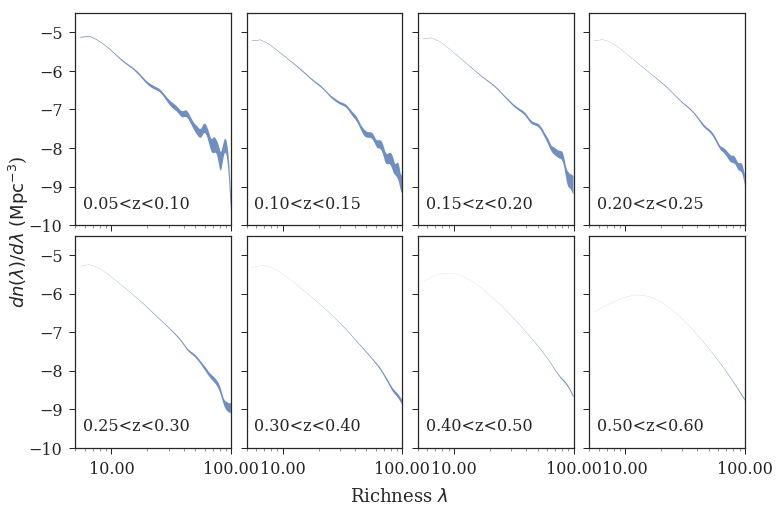

In [261]:
fig_noflambda(png='noflambda.png')

Reading /Users/ioannis/research/projects/legacyhalos/sample/nofz-dr6-dr7.fits
Writing /Users/ioannis/research/projects/legacyhalos/science/paper1/figures/nofz.png


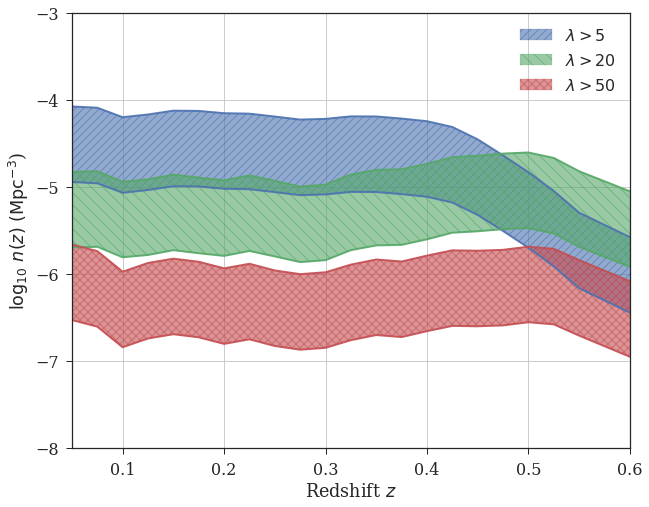

In [153]:
fig_nofz(png='nofz.png')

In [ ]:
stop

### Some useful functions

In [9]:
def get_lambdabins(verbose=False):
    """Fixed bins of richness.
    
    nn = 7
    ll = 10**np.linspace(np.log10(5), np.log10(500), nn)
    #ll = np.linspace(5, 500, nn)
    mh = np.log10(lambda2mhalo(ll))
    for ii in range(nn):
        print('{:.3f}, {:.3f}'.format(ll[ii], mh[ii]))    
    """
    
    # Roughly 13.5, 13.9, 14.2, 14.6, 15, 15.7 Msun
    lambdabins = np.array([5, 10, 20, 40, 80, 250])
    #lambdabins = np.array([5, 25, 50, 100, 500])
    nlbins = len(lambdabins)
    
    mhalobins = np.log10(lambda2mhalo(lambdabins))
    
    if verbose:
        for ii in range(nlbins - 1):
            print('Bin {}: lambda={:03d}-{:03d}, Mhalo={:.3f}-{:.3f} Msun'.format(
                ii, lambdabins[ii], lambdabins[ii+1], mhalobins[ii], mhalobins[ii+1]))
    return lambdabins

In [10]:
def get_zbins(zmin=0.05, zmax=0.6, dt=1.0, verbose=False):
    """Establish redshift bins which are equal in lookback time."""
    import astropy.units as u
    from astropy.cosmology import z_at_value
    
    cosmo = legacyhalos.misc.cosmology()
    tmin, tmax = cosmo.lookback_time([zmin, zmax])
    if verbose:
        print('Cosmic time spanned = {:.3f} Gyr'.format(tmax - tmin))
    
    ntbins = np.round( (tmax.value - tmin.value) / dt + 1 ).astype('int')
    #tbins = np.arange(tmin.value, tmax.value, dt) * u.Gyr
    tbins = np.linspace(tmin.value, tmax.value, ntbins) * u.Gyr
    zbins = np.around([z_at_value(cosmo.lookback_time, tt) for tt in tbins], decimals=3)
    tbins = tbins.value
    
    # Now fix the bins:
    zbins = np.array([0.05, 0.15, 0.25, 0.35, 0.45, 0.6])
    tbins = cosmo.lookback_time(zbins).value
    
    if verbose:
        for ii in range(ntbins - 1):
            print('Bin {}: z={:.3f}-{:.3f}, t={:.3f}-{:.3f} Gyr'.format(
                ii, zbins[ii], zbins[ii+1], tbins[ii], tbins[ii+1]))
    return zbins

In [11]:
lambdabins = get_lambdabins(verbose=True)

Bin 0: lambda=005-010, Mhalo=13.488-13.825 Msun
Bin 1: lambda=010-020, Mhalo=13.825-14.163 Msun
Bin 2: lambda=020-040, Mhalo=14.163-14.500 Msun
Bin 3: lambda=040-080, Mhalo=14.500-14.837 Msun
Bin 4: lambda=080-250, Mhalo=14.837-15.391 Msun


In [12]:
zbins = get_zbins(verbose=True)

Cosmic time spanned = 5.036 Gyr Gyr
Bin 0: z=0.050-0.150, t=0.674-1.886 Gyr
Bin 1: z=0.150-0.250, t=1.886-2.942 Gyr
Bin 2: z=0.250-0.350, t=2.942-3.864 Gyr
Bin 3: z=0.350-0.450, t=3.864-4.673 Gyr
Bin 4: z=0.450-0.600, t=4.673-5.710 Gyr


### Figure: Stellar mass function in bins of redshift and richness

In [216]:
def smf(mstarlim=(9, 14), deltam=0.1, png=None):
    """Stellar mass function in bins of redshift and lambda.
    
    """
    import matplotlib.ticker as ticker
    from scipy.stats import binned_statistic_2d, poisson
    from astropy.modeling import models, fitting

    def weighted_avg_and_std(values, weights):
        """https://stackoverflow.com/questions/2413522/weighted-standard-deviation-in-numpy/2415343#2415343
        """
        avg = np.average(values, weights=weights)
        variance = np.average( (values-avg)**2, weights=weights )
        return avg, np.sqrt(variance)
    
    # Bin the sample by redshift and richness.
    mstar, merr = isedfit_lsphot['MSTAR_AVG'], isedfit_lsphot['MSTAR_ERR']
    zobj, richness = sample['Z'], sample['LAMBDA_CHISQ']

    zbins = get_zbins()
    richbins = get_lambdabins()

    nzedges = len(zbins)-1
    nredges = len(richbins)-1

    count, xedges, yedges, binnumber = binned_statistic_2d(
        zobj, richness, mstar, statistic='count', bins=(zbins[1:], richbins[1:]),
        expand_binnumbers=True)
    
    # Make the plot!
    nmstarbin = np.int( (mstarlim[1] - mstarlim[0]) / deltam )

    xlim = (mstarlim[0] - 0.5, mstarlim[1] + 0.5)
    ylim = (0, 5.5)
    
    fig, ax = plt.subplots(nredges, nzedges, figsize=(14, 10), 
                           sharex=True, sharey=True)
    for iz in range(nzedges):
        for ir in range(nredges):
            these = (binnumber[0, :] == iz) * (binnumber[1, :] == ir)
            if np.count_nonzero(these) > 0:
                zz = zobj[these]
                lam = richness[these]
                ngal, mstarbins = np.histogram(mstar[these], bins=nmstarbin, 
                                               range=mstarlim)
                xmstar = (mstarbins[:-1] + mstarbins[1:]) / 2

                # Get the uncertainties on the points.
                ngalconf = poisson.interval(0.95, ngal)
                ngalerrlo = ngal - ngalconf[0]
                ngalerrhi = ngalconf[1] - ngal
                
                good = ngal > 0
                xmstar = xmstar[good]
                ngal = ngal[good]
                ngalerrlo = ngalerrlo[good]
                ngalerrhi = ngalerrhi[good]
                
                # Take the log
                ngalerrlo = ngalerrlo / ngal / np.log(10)
                ngalerrhi = ngalerrhi / ngal / np.log(10)
                ngal = np.log10(ngal)
                
                
                # Finally make the plot
                ax[ir, iz].errorbar(xmstar, ngal, yerr=[ngalerrlo, ngalerrhi], 
                                    fmt='s', markersize=5, capthick=2,
                                    capsize=2, zorder=2)
                
                ax[ir, iz].set_xlim(xlim)
                ax[ir, iz].set_ylim(ylim)
                ax[ir, iz].margins(0)
                ax[ir, iz].xaxis.set_major_locator(ticker.MultipleLocator(1))
                
                if ir == nredges-1:
                    ax[ir, iz].set_xlabel(mstar_label())
                if iz == 0:
                    ax[ir, iz].set_ylabel(r'$\log_{10}(Number)$')
                if iz == nzedges-1:
                    ax[ir, iz].text(0.95, 0.85, '${:d}<\lambda<{:d}$'.format(richbins[ir], richbins[ir+1]),
                                    fontsize=14, va='center', ha='right', transform=ax[ir, iz].transAxes)
                if ir == 0:
                    ax[ir, iz].set_title(r'${:.2f}<z<{:.2f}$'.format(zbins[iz], zbins[iz+1]),
                                         fontsize=16)
                    
                # Fit and plot a Gaussian model!
                if len(ngal) > 5:
                    ginit = models.Gaussian1D(ngal.max(), mean=np.mean(mstarlim), 
                                              stddev=0.3)
                    gfit = fitting.LevMarLSQFitter()
                    ygauss = gfit(ginit, xmstar, ngal)
                    xgauss = np.linspace(xlim[0], xlim[1], nmstarbin*5)
                    ax[ir, iz].plot(xgauss, ygauss(xgauss), '-', lw=2, color='black',
                                   zorder=20, alpha=0.6)
                    
                # Get the weighted mean stellar mass and standard deviation in this bin.
                #mstaravg, mstarsig = weighted_avg_and_std(xmstar, ngal)
                
                #ax[iz, ir].hist(mstar[these])
                #print(np.sum(these), zz.min(), zz.max(), lam.min(), lam.max(), mstaravg, mstarsig)
        #print()
    
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    
    if png:
        pngfile = os.path.join(figdir, png)
        print('Writing {}'.format(pngfile))
        fig.savefig(pngfile, bbox_inches='tight', pad_inches=0)    

Writing /Users/ioannis/research/projects/legacyhalos/science/paper1/figures/smf_redshift_richness.png


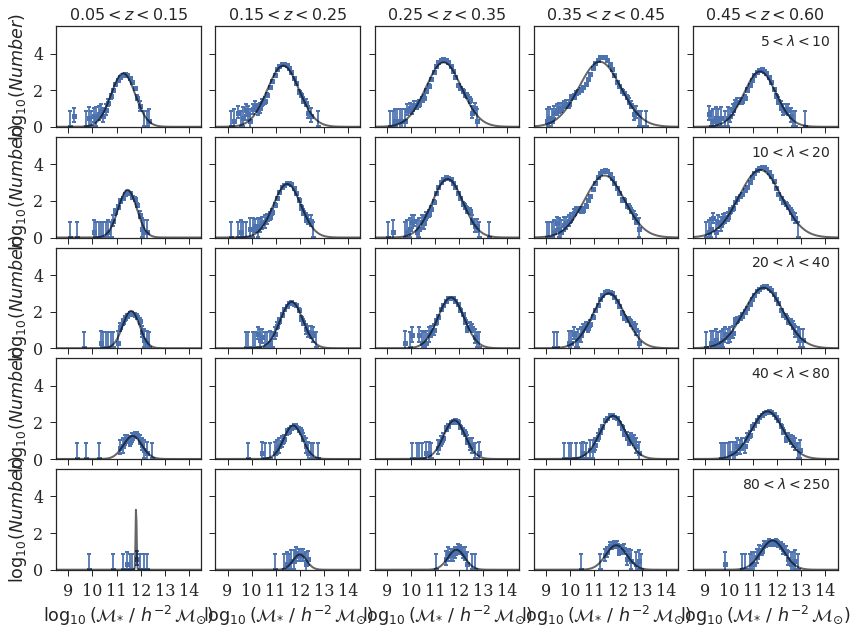

In [217]:
smf(png='smf_redshift_richness.png')

In [ ]:
stop

### Figure: Richness vs redshift

In [ ]:
def fig_lambda_redshift(png=None):

    cmap = 'viridis' # 'RdYlBu'
    xmin, xmax = 0.05, 0.6
    ymin, ymax = np.log10(5), 2.1
    
    j = sns.jointplot(sample['Z'], np.log10(sample['LAMBDA_CHISQ']), kind='hex', #space=0, 
                      stat_func=None, cmap=cmap, mincnt=3, bins='log', gridsize=150,
                      xlim=(xmin, xmax), ylim=(ymin, ymax),
                      marginal_kws={'hist_kws': {'color': 'black'}})
    j.set_axis_labels('Redshift', r'$\log_{10}$ (Richness $\lambda$)')
    #j.ax_joint.axvline(x=0.05, color='k', lw=2, alpha=0.5)
    #j.ax_joint.axvline(x=0.6, color='k', lw=2, alpha=0.5)
    j.ax_joint.margins(0)

    j.fig.set_figwidth(10)
    j.fig.set_figheight(6)
    
    #ax.axhline(y=np.log10(5), ls='--', color='k')

    cax = j.fig.add_axes([0.18, -0.08, 0.65, 0.05])
    cb = plt.colorbar(orientation='horizontal', cax=cax)
    cb.set_label(r'$\log_{10}$ (Number of Centrals)')       

    ax2 = j.ax_marg_y.twinx()
    ax2.set_ylabel(r'$\log_{10}\, (\mathcal{M}_{200}\, /\, \mathcal{M}_{\odot})$ at $z=0.4$')
    ax2.set_ylim( np.log10(lambda2mhalo(10**ymin, redshift=0.4)), 
                  np.log10(lambda2mhalo(10**ymax, redshift=0.4)) )
    #ax2.plot([],[])
    sns.despine(ax=ax2, left=True, right=False)
    ax2.spines['bottom'].set_color('white')
    
    if png:
        pngfile = os.path.join(figdir, png)
        print('Writing {}'.format(pngfile))
        j.fig.savefig(pngfile, bbox_inches='tight', pad_inches=0)

In [ ]:
fig_lambda_redshift(png='lambda_redshift.png')

### Figure: Central galaxy montage

Add code here!

### Figure: RA, Dec of parent sample

ToDo:
* Limit the declination to ~-20 deg or so;
* Add the DESI and/or SDSS footprint;
* Correct for partial pixels.

In [ ]:
def fig_radec(png=None):
    from legacyhalos.desiutil import init_sky, plot_sky_binned
    fig, ax = plt.subplots(figsize=(8, 8))

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        basemap = init_sky(galactic_plane_color='k', ax=ax)
        _, grid_data = plot_sky_binned(sample['RA'], sample['DEC'], #weights=data['WEIGHT'],
                                       max_bin_area=1.0, verbose=True, clip_lo='!1', cmap='viridis',
                                       plot_type='healpix', basemap=basemap,
                                       label=r'$N$(Central Galaxies) (deg$^{-2}$)',
                                       return_grid_data=True)
    print('Median density = {:.3f}/deg2'.format(ma.median(grid_data)))

    if png:
        pngfile = os.path.join(figdir, png)
        print('Writing {}'.format(pngfile))
        fig.savefig(pngfile, bbox_inches='tight', pad_inches=0)

In [ ]:
fig_radec(png='radec.png')

In [ ]:
stop

### Richness-redshift and halo mass-redshift relations.

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

hb = ax.hexbin(rm['Z'], np.log10(rm['LAMBDA_CHISQ']), mincnt=3,
               cmap=plt.cm.get_cmap('RdYlBu'), alpha=0.5, bins='log')
ax.set_xlabel('Redshift $z$')
ax.set_ylabel(r'$\log_{10}$ (Richness $\lambda$)')
ax.set_xlim(0, 0.6)
ymin, ymax = np.log10(3), 2.3
ax.set_ylim(ymin, ymax)
ax.axhline(y=np.log10(5), ls='--', color='k')

cax = fig.add_axes([0.1, 1.05, 0.8, 0.05])
cb = plt.colorbar(hb, orientation='horizontal', cax=cax)
cb.set_label(r'$\log_{10}$ (Number of Galaxies)')       

ax2 = ax.twinx()
ax2.set_ylabel(r'$\log_{10}\, (M_{200}\, /\, M_{\odot})$ at $z=0.3$')
ax2.set_ylim( np.log10(lambda2mhalo(ymin)), np.log10(lambda2mhalo(ymax)) )
ax2.plot([],[])

### Compare LS/SDSS magnitudes and colors.

In [ ]:
def unextinct_sdssphot(phot):
    """Correct SDSS photometry for MW extinction and compute colors."""
    dtype = [('g', 'f4'), ('r', 'f4'), ('z', 'f4'), 
             ('W1', 'f4'), ('W2', 'f4'), 
             ('gr', 'f4'), ('rz', 'f4')]
    result = np.zeros(len(phot), dtype=dtype)
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        ugriz = 22.5 - 2.5 * np.log10(phot['CMODELMAGGIES']) - phot['EXTINCTION']
    
        result['g'] = ugriz[:, 1]
        result['r'] = ugriz[:, 2]
        result['z'] = ugriz[:, 4]
        result['gr'] = result['g'] - result['r']
        result['rz'] = result['r'] - result['z']
        
    return Table(result)

In [ ]:
def unextinct_lsphot(phot):
    """Correct LS photometry for MW extinction and compute colors."""
    dtype = [('g', 'f4'), ('r', 'f4'), ('z', 'f4'), 
             ('W1', 'f4'), ('W2', 'f4'), 
             ('gr', 'f4'), ('rz', 'f4')]
    result = np.zeros(len(phot), dtype=dtype)

    g = phot['FLUX_G'] / phot['MW_TRANSMISSION_G']
    r = phot['FLUX_R'] / phot['MW_TRANSMISSION_R']
    z = phot['FLUX_Z'] / phot['MW_TRANSMISSION_Z']
    W1 = phot['FLUX_W1'] / phot['MW_TRANSMISSION_W1']
    W2 = phot['FLUX_W2'] / phot['MW_TRANSMISSION_W2']
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        result['g'] = 22.5 - 2.5 * np.log10(g)
        result['r'] = 22.5 - 2.5 * np.log10(r)
        result['z'] = 22.5 - 2.5 * np.log10(z)
        result['W1'] = 22.5 - 2.5 * np.log10(W1)
        result['W2'] = 22.5 - 2.5 * np.log10(W2)
        result['gr'] = result['g'] - result['r']
        result['rz'] = result['r'] - result['z']
        
    return Table(result)

In [ ]:
ls = unextinct_lsphot(lsphot)

In [ ]:
sdss = unextinct_sdssphot(sdssphot)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4), sharey=True)
for ii, band in enumerate(('g', 'r', 'z')):
    hb = ax[ii].hexbin(ls[band], sdss[band], mincnt=1,
                cmap=plt.cm.Blues_r, alpha=0.5, bins='log')
    ax[ii].set_xlim(13, 25)
    ax[ii].set_ylim(13, 25)
    #ax[ii].legend(loc='upper left')
    ax[ii].plot([10, 30], [10, 30], color='k', ls='--')
    ax[ii].set_xlabel('mag (SDSS)')
ax[0].set_ylabel('mag (LS)')
cb = plt.colorbar(hb)
cb.set_label(r'$\log_{10}$ (Number of Galaxies)')
fig.subplots_adjust(wspace=0.05)

### Compare LS/UPenn magnitudes and colors.

In [ ]:
lsupenn = Table(fits.getdata(parentupennfile, extname='LSPHOT'))

In [ ]:
sdssupenn = Table(fits.getdata(parentupennfile, extname='SDSSPHOT'))

In [ ]:
upenn = Table(fits.getdata(parentupennfile, extname='UPENN'))
upenn.colnames

In [ ]:
lsupennphot = unextinct_lsphot(lsupenn)
sdssupennphot = unextinct_sdssphot(sdssupenn)

In [ ]:
minmag, maxmag = 14, 20
fig, ax = plt.subplots(1, 2, figsize=(11, 4), sharey=True)
for ii, band in enumerate(('g', 'r')):
    hb = ax[ii].hexbin(upenn['{}_M_TOT'.format(band.upper())], sdssupennphot[band], 
                       mincnt=1, cmap=plt.cm.Blues_r, alpha=0.5, #bins='log',
                       extent=(minmag, maxmag, minmag, maxmag),
                       vmin=0, vmax=15)
    ax[ii].set_xlim(minmag, maxmag)
    ax[ii].set_ylim(minmag, maxmag)
    ax[ii].plot([10, 30], [10, 30], color='k', ls='--')
    ax[ii].set_xlabel('mag (UPenn-PhotDec)')
cax = fig.add_axes([0.92, 0.15, 0.02, 0.72])
cb = plt.colorbar(hb, cax=cax)
cb.set_label('Number of Galaxies per Bin') 
ax[0].set_ylabel('mag (SDSS)')
fig.subplots_adjust(wspace=0.05)

In [ ]:
minmag, maxmag = 14, 20
fig, ax = plt.subplots(1, 2, figsize=(11, 4), sharey=True)
for ii, band in enumerate(('g', 'r')):
    hb = ax[ii].hexbin(upenn['{}_M_TOT'.format(band.upper())], lsupennphot[band], 
                       mincnt=1, cmap=plt.cm.Blues_r, alpha=0.5, #bins='log',
                       extent=(minmag, maxmag, minmag, maxmag),
                       vmin=0, vmax=15)
    ax[ii].set_xlim(minmag, maxmag)
    ax[ii].set_ylim(minmag, maxmag)
    ax[ii].plot([10, 30], [10, 30], color='k', ls='--')
    ax[ii].set_xlabel('mag (UPenn-PhotDec)')
cax = fig.add_axes([0.92, 0.15, 0.02, 0.72])
cb = plt.colorbar(hb, cax=cax)
cb.set_label('Number of Galaxies per Bin')
#cb.set_label(r'$\log_{10}$ (Number of Galaxies)')    
ax[0].set_ylabel('mag (LS)')
fig.subplots_adjust(wspace=0.05)